In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from custom import weather

import re
import folium
import geocoder
import base64

matplotlib.rcParams['font.family'] = ['PingFang HK']
def rmax(maxrow: int=50):
    pd.set_option('display.max_rows', maxrow)
def cmax(maxcol: int=50):
    pd.set_option('display.max_columns', maxcol)

%load_ext autoreload
%autoreload 2

### load from saved dataframe

In [2]:
df = pd.read_csv('all_station_20201126.csv')
df.shape

(608, 16)

In [3]:
## keep only stations with data more than 1 year
df = df[df.data_duration>=12]
df.shape

(586, 16)

## Load cleaned weather data

In [4]:
df_w = pd.read_pickle('weather_all_cleaned.bz2')

## make wind dir bins

In [5]:
#direction 0 means no wind, not direction, north is 360
df_w['WD'].replace({0: np.nan}, inplace=True)
df_w['WD'].min()

1.0

In [6]:
bin_width = 10
nbin = 360//bin_width

# make Wind direction binning
bin_edge = np.linspace(bin_width//2, 360+bin_width//2, nbin+1)
bin_label = list(range(bin_width,360+bin_width,bin_width)) ## label is at the center of the bin (label:10 for edge[5,15])
print(bin_edge, bin_label)

## shift the 1-(bin_width/2) degree to 360+ for better binning representation 
## i.e. 3 would be shifted to 363 and belongs to the bin 360
## while bin 10 is for 5-15
df_w['WD_shifted'] = df_w['WD']
df_w.loc[df_w.WD<bin_width//2, 'WD_shifted'] = df_w.WD+360
col_WD_bin = f'WD_bin_{bin_width}'
df_w[col_WD_bin] = pd.cut(df_w.WD_shifted, bins=bin_edge, labels=bin_label)

[  5.  15.  25.  35.  45.  55.  65.  75.  85.  95. 105. 115. 125. 135.
 145. 155. 165. 175. 185. 195. 205. 215. 225. 235. 245. 255. 265. 275.
 285. 295. 305. 315. 325. 335. 345. 355. 365.] [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360]


In [7]:
# move index for easier grouping
df_w.reset_index(inplace=True)
df_w['month'] = df_w.date.dt.month
df_w['year'] = df_w.date.dt.year

### test the binning counting process

In [31]:
## verify there is no WD = 0
df_w.WD.value_counts()

1.0      15074
2.0      13199
3.0      11952
10.0     11656
4.0      11061
         ...  
293.0     1008
245.0     1001
292.0      998
288.0      979
289.0      961
Name: WD, Length: 360, dtype: int64

In [32]:
test = df_w[(df_w.stn_code=='466880')]

<AxesSubplot:>

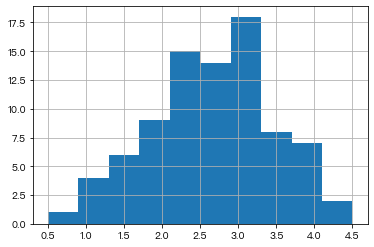

In [33]:
test.loc[(test.month==1) & (test[col_WD_bin]==70), 'WS'].hist()

In [34]:
test.loc[(test.month==1) & (test[col_WD_bin]==70), 'WS'].mode()

0    1.9
1    2.3
2    2.4
3    3.0
4    3.2
5    3.3
dtype: float64

In [35]:
test.loc[(test.month==1) & (test[col_WD_bin]==70), 'WS'].median()

2.75

In [36]:
rmax(500)
test2 = test.groupby(['stn_code', 'month', col_WD_bin]).agg(dict(WD='count', WS='median'))
test2

WD    WS
stn_code month WD_bin_10          
466880   1     10          2  0.90
               20          3  1.10
               30          1  1.10
               40          2  1.75
               50          5  1.30
               60         41  2.50
               70         84  2.75
               80         15  2.60
               90          0   NaN
               100         0   NaN
               110         0   NaN
               120         0   NaN
               130         0   NaN
               140         0   NaN
               150         0   NaN
               160         0   NaN
               170         0   NaN
               180         0   NaN
               190         2  0.90
               200        13  1.00
               210         5  1.40
               220         6  1.10
               230         0   NaN
               240         1  0.30
               250         0   NaN
               260         2  1.55
               270         1  1.00
               280         0   NaN
               290         0   NaN
               300         0   NaN
               310         1  1.00
               320         0   NaN
               330         0   NaN
               340         1  1.20
               350         1  0.90
               360         0   NaN
         2     10          0   NaN
               20          2  0.75
               30          6  0.90
               40          7  1.40
               50          5  1.10
               60         40  2.05
               70         67  2.30
               80         10  2.10
               90          0   NaN
               100         0   NaN
               110         0   NaN
               120         0   NaN
               130         0   NaN
               140         0   NaN
               150         0   NaN
               160         0   NaN
               170         0   NaN
               180         0   NaN
               190         1  1.70
               200        17  0.90
               210         7  1.00
               220         3  0.60
               230         3  0.80
               240         0   NaN
               250         0   NaN
               260         1  0.80
               270         0   NaN
               280         0   NaN
               290         0   NaN
               300         1  1.00
               310         0   NaN
               320         0   NaN
               330         0   NaN
               340         0   NaN
               350         0   NaN
               360         0   NaN
         3     10          1  1.40
               20          1  1.20
               30          7  1.50
               40          3  0.90
               50         13  1.10
               60         52  2.35
               70         59  2.30
               80          5  2.10
               90          0   NaN
               100         0   NaN
               110         0   NaN
               120         0   NaN
               130         0   NaN
               140         0   NaN
               150         0   NaN
               160         0   NaN
               170         0   NaN
               180         0   NaN
               190         2  0.90
               200        18  0.85
               210         5  0.80
               220         8  1.00
               230         4  0.90
               240         2  0.80
               250         1  0.70
               260         1  0.80
               270         2  0.80
               280         0   NaN
               290         0   NaN
               300         0   NaN
               310         0   NaN
               320         0   NaN
               330         1  1.40
               340         0   NaN
               350         1  0.60
               360         0   NaN
         4     10          0   NaN
               20          1  1.10
               30          1  0.90
               40          3  1.40
               50          7  1.00
 

In [37]:
test3 = test2.loc[test2.groupby(level=[0,1]).WD.idxmax()]
test3

WD    WS
stn_code month WD_bin_10          
466880   1     70         84  2.75
         2     70         67  2.30
         3     70         59  2.30
         4     60         56  2.25
         5     60         60  1.85
         6     220        36  2.00
         7     200        34  1.25
         8     70         44  1.95
         9     70         58  2.10
         10    70         99  2.80
         11    70         91  2.70
         12    70         79  2.70

In [38]:
test4 = test3.reset_index(-1).drop(columns='WD')
rmax(50)
test4.columns = ['WD', 'WS']

In [39]:
test4 = test4.unstack()
test4.columns = [f'{col[1]}_{col[0]}' for col in test4.columns.values]
test4

,1_WD,2_WD,3_WD,4_WD,5_WD,6_WD,7_WD,8_WD,9_WD,10_WD,11_WD,12_WD,1_WS,2_WS,3_WS,4_WS,5_WS,6_WS,7_WS,8_WS,9_WS,10_WS,11_WS,12_WS
stn_code,,,,,,,,,,,,,,,,,,,,,,,,
466880,70,70,70,60,60,220,200,70,70,70,70,70,2.75,2.3,2.3,2.25,1.85,2.0,1.25,1.95,2.1,2.8,2.7,2.7


## make a wide format of dominant WD per month per station

In [8]:
## calculate occurance, and median WS per direction, per month, per station
temp = df_w.groupby(['stn_code', 'month', col_WD_bin]).agg(dict(WD='count', WS='median'))
## find the most frequent wind direction
temp = temp.loc[temp.groupby(level=[0,1]).WD.idxmax()]
## clean up 
temp = temp.reset_index(-1).drop(columns='WD')
temp.columns = ['WD', 'WS']
## make a wide table
wind_mode= temp.unstack()
wind_mode.columns = [f'{col[1]}_{col[0]}' for col in wind_mode.columns.values]
wind_mode

,1_WD,2_WD,3_WD,4_WD,5_WD,6_WD,7_WD,8_WD,9_WD,10_WD,...,3_WS,4_WS,5_WS,6_WS,7_WS,8_WS,9_WS,10_WS,11_WS,12_WS
stn_code,,,,,,,,,,,,,,,,,,,,,
466880,70,70,70,60,60,220,200,70,70,70,...,2.3,2.25,1.85,2.00,1.25,1.95,2.1,2.80,2.70,2.70
466900,20,20,20,140,150,150,150,150,150,20,...,2.1,1.35,1.30,1.10,1.55,1.25,1.2,1.70,1.90,2.25
466910,190,350,190,360,360,360,350,350,350,190,...,1.9,2.25,1.90,1.90,1.70,1.95,2.1,3.70,3.35,2.40
466920,50,50,50,80,80,160,180,80,80,50,...,3.0,3.30,2.45,1.40,1.70,2.60,2.5,3.50,3.10,3.20
466930,30,30,30,30,30,320,50,60,30,30,...,3.2,3.00,2.35,1.30,0.80,1.00,2.2,3.05,3.30,3.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C0Z290,10,360,10,10,10,130,130,40,10,20,...,0.6,0.45,0.75,0.95,1.10,0.70,0.7,0.70,0.85,1.30
C0Z300,10,10,10,10,10,50,50,10,10,10,...,1.1,0.90,0.80,1.90,2.00,0.90,1.1,1.30,1.00,1.50
C0Z310,360,360,360,360,360,360,360,360,360,360,...,1.1,1.10,1.00,0.90,1.10,0.90,0.9,1.00,1.00,0.85


In [9]:
## merge it with the all station dataframe
df_merge = pd.merge(df, wind_mode.reset_index(), how='inner', left_on='stn_code', right_on='stn_code')

In [10]:
cmax(100)
df_merge

,stn_code,stn_name,altitude,Longitude,Latitude,city,address,data_start_date,stn_end_date,comment,orig_stn_code,new_stn_code,data_start_date2,data_duration,data_duration2,data_period,1_WD,2_WD,3_WD,4_WD,5_WD,6_WD,7_WD,8_WD,9_WD,10_WD,11_WD,12_WD,1_WS,2_WS,3_WS,4_WS,5_WS,6_WS,7_WS,8_WS,9_WS,10_WS,11_WS,12_WS
0,466880,板橋,9.7,121.442017,24.997647,新北市,板橋區大觀路二段265巷62號,1972/03/01,NaN,原為探空站，自2002年開始進行氣象觀測。因受附近興建合宜住宅影響，日照觀測自民國104年起...,NaN,NaN,2015-01-01,70,5年10個月,1972/03/01-2020/11/26,70,70,70,60,60,220,200,70,70,70,70,70,2.75,2.30,2.3,2.25,1.85,2.00,1.25,1.95,2.1,2.80,2.70,2.70
1,466900,淡水,19.0,121.448906,25.164889,新北市,淡水區中正東路42巷6號,1942/01/01,NaN,NaN,NaN,NaN,2015-01-01,70,5年10個月,1942/01/01-2020/11/26,20,20,20,140,150,150,150,150,150,20,20,20,2.15,2.20,2.1,1.35,1.30,1.10,1.55,1.25,1.2,1.70,1.90,2.25
2,466910,鞍部,837.6,121.529731,25.182586,臺北市,北投區陽明山竹子湖路111號,1937/01/01,NaN,NaN,NaN,NaN,2015-01-01,70,5年10個月,1937/01/01-2020/11/26,190,350,190,360,360,360,350,350,350,190,180,190,2.70,2.70,1.9,2.25,1.90,1.90,1.70,1.95,2.1,3.70,3.35,2.40
3,466920,臺北,5.3,121.514853,25.037658,臺北市,中正區公園路64號,1896/01/01,NaN,2014至2015氣候年報之氣壓計海面上高度應為30.3m(2014/10/25搬遷，6.6...,NaN,NaN,2015-01-01,70,5年10個月,1896/01/01-2020/11/26,50,50,50,80,80,160,180,80,80,50,50,50,3.40,2.60,3.0,3.30,2.45,1.40,1.70,2.60,2.5,3.50,3.10,3.20
4,466930,竹子湖,607.1,121.544547,25.162078,臺北市,北投區陽明山竹子湖路2號,1937/01/01,NaN,NaN,NaN,NaN,2015-01-01,70,5年10個月,1937/01/01-2020/11/26,30,30,30,30,30,320,50,60,30,30,30,30,4.05,3.20,3.2,3.00,2.35,1.30,0.80,1.00,2.2,3.05,3.30,3.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,C0Z290,赤柯山,946.0,121.382930,23.368930,花蓮縣,玉里鎮赤柯山段338地號,2017/12/01,NaN,NaN,NaN,NaN,2017-12-01,35,2年11個月,2017/12/01-2020/11/26,10,360,10,10,10,130,130,40,10,20,10,20,1.10,0.35,0.6,0.45,0.75,0.95,1.10,0.70,0.7,0.70,0.85,1.30
442,C0Z300,東里,182.0,121.305470,23.268530,花蓮縣,富里鄉東里村大莊路52號(東里消防分隊),2017/12/01,NaN,NaN,NaN,NaN,2017-12-01,35,2年11個月,2017/12/01-2020/11/26,10,10,10,10,10,50,50,10,10,10,10,10,1.10,1.10,1.1,0.90,0.80,1.90,2.00,0.90,1.1,1.30,1.00,1.50
443,C0Z310,清水斷崖,59.0,121.689142,24.218294,花蓮縣,秀林鄉臺9線大清水遊憩區下方空地,2018/03/23,NaN,NaN,NaN,NaN,2018-03-23,32,2年8個月,2018/03/23-2020/11/26,360,360,360,360,360,360,360,360,360,360,360,360,1.10,0.90,1.1,1.10,1.00,0.90,1.10,0.90,0.9,1.00,1.00,0.85
444,C0Z320,清水林道,646.0,121.188272,23.271250,花蓮縣,卓溪鄉清水林道北側山區(新生段1地號),2018/05/09,NaN,NaN,NaN,NaN,2018-05-09,30,2年6個月,2018/05/09-2020/11/26,60,50,50,50,50,360,50,50,50,50,50,60,0.60,0.70,0.6,0.60,0.60,0.60,1.00,0.80,0.8,0.40,0.50,0.30


## test the mplleaflet quiver plot function

In [11]:
xy = np.array(df_merge[['Longitude', 'Latitude']])
xy.shape

(446, 2)

In [12]:
import pyproj
import mplleaflet

# Transform the data to other proj system (not required...)
# proj_in = pyproj.Proj(preserve_units=True, init='epsg:4326', no_defs=True)
# crs_out = {'init': 'epsg:3857', 'no_defs': True}
# proj_out = pyproj.Proj(preserve_units=True, **crs_out)
# xy2 = np.array([pyproj.transform(proj_in, proj_out, c[0], c[1]) for c in xy])
# xy2

In [13]:
m=1
vector_scale = 1

# Grab the speed (m/s)
speed = np.array(df_merge.loc[:,f'{m}_WS'])
speed.shape

(446,)

In [14]:
# Grab the WD. WD is 0 degrees due North, increasing clockwise
direction = np.array(df_merge.loc[:,f'{m}_WD'])
direction.shape

(446,)

In [15]:
#### Convert angle corresponding to cartesian coordinates and make the arrow point to opposite dir. of wind
angle = np.deg2rad(-90-direction)
angle.shape

(446,)

In [16]:
# Normalize the speed to use as the length of the arrows
r = vector_scale * speed/max(speed)
uv = r[:, np.newaxis] * np.column_stack([np.cos(angle), np.sin(angle)])
# uv

In [17]:
table = pd.DataFrame(data={'x_in':xy[:,0],
                        'y_in':xy[:,1],
                        'x_out':xy2[:,0],
                        'y_out':xy2[:,1],
                        'speed':speed,
                        'dir':direction,
                        'angle':angle,
                        'u':uv[:,0],
                        'v':uv[:,1],
                        'r':r})
# table



NameError: name 'xy2' is not defined

In [18]:
matplotlib.rcParams['image.cmap']

'viridis'

<Figure size 432x288 with 0 Axes>

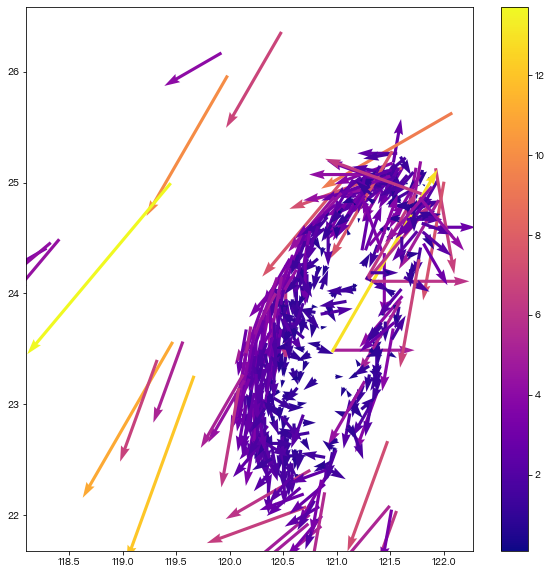

In [19]:
plt.set_cmap('plasma')
fig, ax = plt.subplots(figsize=(10,10))
q = ax.quiver(xy[:,0], xy[:,1], uv[:,0], uv[:,1], speed[:], scale=2, alpha=1, width=0.007)
fig.colorbar(q, ax=ax)

In [472]:
gj = mplleaflet.fig_to_geojson(fig=fig)

/Users/qzt/miniconda3/envs/data/lib/python3.7/site-packages/mplleaflet/mplexporter/exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]


## get maximum WS over whole dataset (for scaling colorbar)

In [20]:
wscols = re.findall('[0-9]{1,2}_WS', " ".join(df_merge.columns))
wscols

['1_WS',
 '2_WS',
 '3_WS',
 '4_WS',
 '5_WS',
 '6_WS',
 '7_WS',
 '8_WS',
 '9_WS',
 '10_WS',
 '11_WS',
 '12_WS']

In [21]:
idx = df_merge[wscols].idxmax()
df_merge.iloc[idx]

,stn_code,stn_name,altitude,Longitude,Latitude,city,address,data_start_date,stn_end_date,comment,orig_stn_code,new_stn_code,data_start_date2,data_duration,data_duration2,data_period,1_WD,2_WD,3_WD,4_WD,5_WD,6_WD,7_WD,8_WD,9_WD,10_WD,11_WD,12_WD,1_WS,2_WS,3_WS,4_WS,5_WS,6_WS,7_WS,8_WS,9_WS,10_WS,11_WS,12_WS
397,C0W160,烏坵,49.0,119.449560,24.994400,金門縣,烏坵鄉,2016/08/17,NaN,NaN,NaN,NaN,2016-08-17,51,4年3個月,2016/08/17-2020/11/26,40,50,40,30,40,220,220,230,50,50,40,40,13.70,15.00,11.80,9.0,11.3,7.15,5.60,5.3,14.0,16.50,17.00,16.6
397,C0W160,烏坵,49.0,119.449560,24.994400,金門縣,烏坵鄉,2016/08/17,NaN,NaN,NaN,NaN,2016-08-17,51,4年3個月,2016/08/17-2020/11/26,40,50,40,30,40,220,220,230,50,50,40,40,13.70,15.00,11.80,9.0,11.3,7.15,5.60,5.3,14.0,16.50,17.00,16.6
397,C0W160,烏坵,49.0,119.449560,24.994400,金門縣,烏坵鄉,2016/08/17,NaN,NaN,NaN,NaN,2016-08-17,51,4年3個月,2016/08/17-2020/11/26,40,50,40,30,40,220,220,230,50,50,40,40,13.70,15.00,11.80,9.0,11.3,7.15,5.60,5.3,14.0,16.50,17.00,16.6
187,C0I520,玉山風口,3860.0,120.955994,23.470489,南投縣,信義鄉(玉山主峰往北峰叉路空地附近),2016/05/22,NaN,NaN,NaN,NaN,2016-05-22,54,4年6個月,2016/05/22-2020/11/26,210,210,200,210,210,190,190,340,10,10,190,200,12.95,13.65,8.45,10.1,8.7,3.90,4.70,2.4,2.7,2.30,6.05,9.0
397,C0W160,烏坵,49.0,119.449560,24.994400,金門縣,烏坵鄉,2016/08/17,NaN,NaN,NaN,NaN,2016-08-17,51,4年3個月,2016/08/17-2020/11/26,40,50,40,30,40,220,220,230,50,50,40,40,13.70,15.00,11.80,9.0,11.3,7.15,5.60,5.3,14.0,16.50,17.00,16.6
25,467620,蘭嶼,324.0,121.558339,22.036969,臺東縣,蘭嶼鄉紅頭村2號,1940/01/01,NaN,NaN,NaN,NaN,2015-01-01,70,5年10個月,1940/01/01-2020/11/26,20,20,20,20,250,250,240,250,20,10,10,10,6.30,6.35,5.40,5.4,9.3,11.35,10.35,10.8,5.3,6.15,6.80,7.4
25,467620,蘭嶼,324.0,121.558339,22.036969,臺東縣,蘭嶼鄉紅頭村2號,1940/01/01,NaN,NaN,NaN,NaN,2015-01-01,70,5年10個月,1940/01/01-2020/11/26,20,20,20,20,250,250,240,250,20,10,10,10,6.30,6.35,5.40,5.4,9.3,11.35,10.35,10.8,5.3,6.15,6.80,7.4
25,467620,蘭嶼,324.0,121.558339,22.036969,臺東縣,蘭嶼鄉紅頭村2號,1940/01/01,NaN,NaN,NaN,NaN,2015-01-01,70,5年10個月,1940/01/01-2020/11/26,20,20,20,20,250,250,240,250,20,10,10,10,6.30,6.35,5.40,5.4,9.3,11.35,10.35,10.8,5.3,6.15,6.80,7.4
397,C0W160,烏坵,49.0,119.449560,24.994400,金門縣,烏坵鄉,2016/08/17,NaN,NaN,NaN,NaN,2016-08-17,51,4年3個月,2016/08/17-2020/11/26,40,50,40,30,40,220,220,230,50,50,40,40,13.70,15.00,11.80,9.0,11.3,7.15,5.60,5.3,14.0,16.50,17.00,16.6
397,C0W160,烏坵,49.0,119.449560,24.994400,金門縣,烏坵鄉,2016/08/17,NaN,NaN,NaN,NaN,2016-08-17,51,4年3個月,2016/08/17-2020/11/26,40,50,40,30,40,220,220,230,50,50,40,40,13.70,15.00,11.80,9.0,11.3,7.15,5.60,5.3,14.0,16.50,17.00,16.6


In [22]:
df_merge[wscols].max()

1_WS     13.70
2_WS     15.00
3_WS     11.80
4_WS     10.10
5_WS     11.30
6_WS     11.35
7_WS     10.35
8_WS     10.80
9_WS     14.00
10_WS    16.50
11_WS    17.00
12_WS    16.60
dtype: float64

In [23]:
wsmax = df_merge[wscols].max().max()

### test plot and save a colorbar with given cmap

In [24]:
colorbar_file = 'resources/colorbar.png'
cmap = 'jet'
alpha = 0.8

In [25]:
# Get the colormap colors
cm = plt.get_cmap(cmap)
my_cmap = cm(np.arange(cm.N))
my_cmap[:,-1] = alpha
# Create new colormap
my_cmap = matplotlib.colors.ListedColormap(my_cmap)

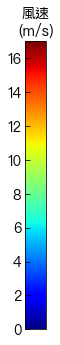

In [26]:
fsize=2,5
plt.figure(figsize=fsize)
a = np.array([[0,wsmax]])
# mat = wsmax * np.random.random((10,10))
# plt.imshow(mat, origin="lower", cmap=my_cmap, interpolation='bilinear')
img = plt.imshow(a, cmap=my_cmap)
plt.gca().set_visible(False)
cax = plt.axes([0.5, 0.1, 0.15, 0.8])
cb = plt.colorbar(orientation="vertical", cax=cax,
                  drawedges=False)
cb.solids.set_edgecolor("face")
cb.ax.set_title('風速\n(m/s)', fontsize=14)
cb.ax.tick_params(size=5, labelsize=14, direction='in')
cax.yaxis.set_ticks_position('left')
plt.savefig(colorbar_file, transparent=True)

## function to convert station coordinate, wd,ws to quiver parameters and geojson

In [27]:
import mplleaflet

def get_windplot_geojson(df, month, vector_length=False, scale=2, 
                         alpha=1, width=0.007, cmap='jet', show=False):
    xy = np.array(df[['Longitude', 'Latitude']])

    # Grab the speed (m/s)
    speed = np.array(df.loc[:,f'{month}_WS'])
    # Grab the WD. WD is 0 degrees due North, increasing clockwise
    direction = np.array(df.loc[:,f'{month}_WD'])
    # Convert angle corresponding to cartesian coordinates and make the arrow point to opposite dir. of wind
    angle = np.deg2rad(-90-direction)
    if vector_length:
        # Normalize the speed to use as the length of the arrows
        r = speed/max(speed)
        uv = r[:, np.newaxis] * np.column_stack([np.cos(angle), np.sin(angle)])
    else:
        uv = 1 * np.column_stack([np.cos(angle), np.sin(angle)])

    plt.set_cmap(cmap)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.quiver(xy[:,0], xy[:,1], uv[:,0], uv[:,1], speed[:], scale=scale, alpha=1, width=0.007)
    if show:
        plt.show()
    
    return mplleaflet.fig_to_geojson(fig=fig)

<Figure size 432x288 with 0 Axes>

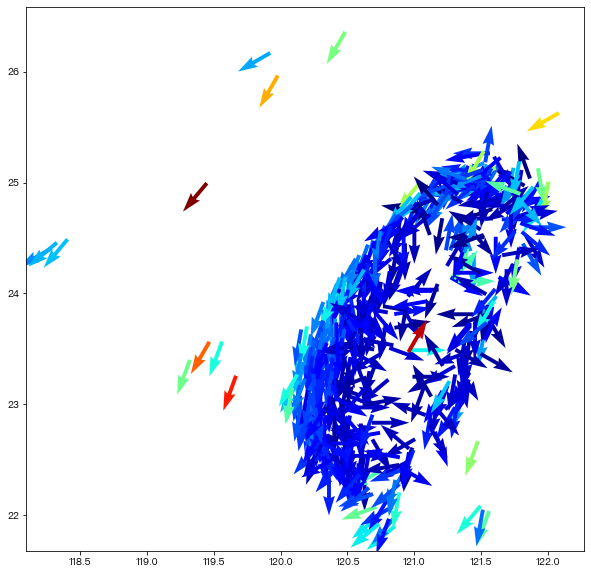

/Users/qzt/miniconda3/envs/data/lib/python3.7/site-packages/mplleaflet/mplexporter/exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]


In [28]:
gj1 = get_windplot_geojson(df_merge, 1, vector_length=False, scale=15, cmap=cmap, show=True)

In [29]:
import folium.plugins as plugins


# create the location map
g = geocoder.osm("Taiwan")
latitude = g.latlng[0]
longitude = g.latlng[1]
print(latitude, longitude)

# create the main map
f = folium.Figure(width=1200, height=900)
# map_ = folium.Map(location=[latitude, longitude],
#                   zoom_start=8,
#                   min_zoom=7,
#                   control_scale=True,
#                   control=False
#                   ).add_to(f)
map_ = folium.Map(location=[latitude, longitude], tiles=None, zoom_start=8)

folium.TileLayer(tiles='OpenStreetMap',attr='OSM',
                 show=True, control=True,
                    min_zoom=7).add_to(map_)
            

#create the quiver group1
feature_groups = {}

for m in range(1,2):
    month = datetime.strptime(str(m), '%m').strftime('%b')
    
    show = True if m==1 else False
    feature_groups[month] = folium.FeatureGroup(name=month, overlay=True, show=show)
    gj = get_windplot_geojson(df_merge, m, vector_length=False, scale=20, cmap='jet')
    
    for feature in gj['features']:
        if feature['geometry']['type'] == 'Point':
            lon, lat = feature['geometry']['coordinates']
            div = feature['properties']['html']

            icon_anchor = (feature['properties']['anchor_x'],
                           feature['properties']['anchor_y'])

            icon = folium.features.DivIcon(html=div,
                                           icon_anchor=icon_anchor)
            marker = folium.Marker([lat, lon], icon=icon, opacity=0.7)
            feature_groups[month].add_child(marker)
        else:
            msg = "Unexpected geometry {}".format
            raise ValueError(msg(feature['geometry']))
        
    map_.add_child(feature_groups[month], name=month, index=m)

# map_.add_child(folium.LayerControl(collapsed=False))
encoded = base64.b64encode(open(colorbar_file, 'rb').read())
# html+=f'<img src="data:image/png;base64,{encoded.decode("UTF-8")}" style="width:100%;height:100%;">'
uri = f'data:image/png;base64,{encoded.decode("UTF-8")}'
plugins.FloatImage(uri, bottom=35, left=88).add_to(map_)
map_
        

23.59829785 120.83536313817521


/Users/qzt/miniconda3/envs/data/lib/python3.7/site-packages/mplleaflet/mplexporter/exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]


<Figure size 432x288 with 0 Axes>

## Save map as html
change the leaflet popup background color by inserting an extraline using beautifulsoup...

In [30]:
# map_.save('wind.html')

## Function to add the slide player code into html....(dirty fix)

In [91]:
with open('index.html', "r") as file:
    raw = file.read()
    
var_list = re.findall(r'var ([^= ]*)\s?=\s?.*', raw, re.MULTILINE)
map_id = var_list[0]
idx = raw.index(f'var {var_list[-1]}')
## get the layer group name
data = raw[idx:]
var_list[-3:]

['tile_layer_e5da4c53c77545cbb6d56360cfae6e25',
 'tile_layer_de73085ec2f44b3db9fa956f3e0ba9bb',
 'layer_control_3e5fbdc3ff0b40c4a3de0e1cc048c18f']

In [108]:
m = re.search('overlays :', data)
block_layercontrol = data[:m.start()] + '\n};'

m = re.search('L.control.layers\(', data)
m2 = re.search('</script>', data)
block_layercontrol += data[m.start():m2.start()]

jsbeautifier.beautify(block_layercontrol, opts)

In [92]:
sp2 = re.split('{|},\n', data)
for i, s in enumerate(sp2):
    if s.strip().startswith('base_layers'):
        text_bl = sp2[i+1]
    if s.strip().startswith('overlay'):
        text = sp2[i+1]
        break
l1 = [l.strip(' ,') for l in re.split('\n', text) if l.strip()]
text_bl

'\n                    "openstreetmap" : tile_layer_e5da4c53c77545cbb6d56360cfae6e25,\n                    "\\u5730\\u578b\\u5716" : tile_layer_de73085ec2f44b3db9fa956f3e0ba9bb,\n                '

In [84]:
iter = re.finditer("</script>", raw)
indices = [m.start(0) for m in iter]
indices

[197, 443, 516, 612, 736, 6739969]

In [86]:
raw[6000000:indices[-1]]

'\\" viewBox=\\"-7.499999999999997 -3.5500000000000007 15.0 35.0\\" xmlns=\\"http://www.w3.org/2000/svg\\" version=\\"1.1\\"\\u003e  \\u003cpath d=\\"M 1.953 -5.532398733553252e-16 L 1.9530000000000032 10.322999999999997 L 5.859000000000003 8.369999999999997 L 7.903426762218931e-15 27.9 L -5.858999999999997 8.37 L -1.9529999999999972 10.322999999999997 L -1.953 5.532398733553252e-16 L 1.953 -5.532398733553252e-16\\" stroke=\\"none\\" stroke-width=\\"0\\" stroke-opacity=\\"1\\" fill=\\"#0000E3\\" fill-opacity=\\"1\\" /\\u003e\\u003c/svg\\u003e", "iconAnchor": [7.499999999999997, 3.5500000000000007]});\n            marker_6deb04b1b9d74891b0d19750ce473fb6.setIcon(div_icon_8300f67399b94f1c97c726b5c27e3253);\n        \n    \n            var marker_1f222bc607c24b4c98d12730d28ada70 = L.marker(\n                [23.380878, 120.16778899999998],\n                {"opacity": 0.8}\n            ).addTo(feature_group_5542e5593b8a49c18a0f03f3d4bd1342);\n        \n    \n            var div_icon_d66b5e

In [122]:
import jsbeautifier
opts = jsbeautifier.default_options()
opts.indent_size = 4
opts.wrap_line_length = 70
opts.break_chained_methods = True
opts.indent_level = 3
opts.end_with_newline = True
opts.preserve_newlines = True

def add_slider_html(html_file):
    with open(html_file, "r") as file:
        raw = file.read()
    
    ## fix the header part   
    inject = '\
        \n    <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>\
        \n    <script src="https://cdnjs.cloudflare.com/ajax/libs/jqueryui-touch-punch/0.2.2/jquery.ui.touch-punch.min.js"></script>\
        \n    <script src="src/SliderControl_wind.js"></script>\
        \n    <script src="src/easy-button_wind.js"></script>\
        \n    <link rel="stylesheet" href="https://code.jquery.com/ui/1.9.2/themes/base/jquery-ui.css" type="text/css">\
        \n    <link rel="stylesheet" href="src/wind.css">\
        \n\n'
    idx = raw.index(r'<meta name="viewport"')
    head = raw[:idx].rstrip()
    raw = raw[idx:]
    head +=inject
    raw = head+'\n    '+raw

    ## fix the footer part
    var_list = re.findall(r'var ([^= ]*)\s?=\s?.*', raw, re.MULTILINE)
    map_id = var_list[0]
    idx = raw.index(f'var {var_list[-1]}')
    ## get the layer group name
    data = raw[idx:]
    ## remove the part after layer_control_xxxxx ###
    raw = raw[:idx]
    

    ## extract the layer name and id
    sp2 = re.split('{|},\n', data)
    for i, s in enumerate(sp2):
        if s.strip().startswith('overlay'):
            text = sp2[i+1]
            break
    l1 = [l.strip(' ,') for l in re.split('\n', text) if l.strip()]

    ## construct the layergroup codeblock
    block1 = []
    groups = []
    for l in l1:
        m, g = l.split(':')
        m = m.strip('" ')
        g = g.strip()
        if(m=='station'):
            continue
        groups.append(g)
        block1.append('\n')
        block1.append(g+'.options = {month:"'+m+'"}')
    block1 = "".join(block1)

    ## contruct the layercontrol block
    m = re.search('overlays :', data)
    block_layercontrol = data[:m.start()] + '\n};'
    m = re.search('L.control.layers\(', data)
    m2 = re.search('</script>', data)
    block_layercontrol += data[m.start():m2.start()]
    
    text = f'\n\nmap_var = {map_id};\n\nvar lgs = ['
    text+= ','.join(groups)
    text+= '];\n\nvar sliderControl = L.control.sliderControl({layerGroups:lgs,timeAttribute: "month",startTimeIdx: 0,timeStrLength: 3,range: false,follow: 1});'
    text+= f'\n\nL.control.watermark({{ position: "topright", imgSrc: "{colorbar_file}" }}).addTo(map_var);'
    text+= '\nmap_var.on("popupopen", function (){$(".leaflet-control").addClass("hidden");});'
    text+= '\nmap_var.on("popupclose", function (){$(".leaflet-control").removeClass("hidden");});'
    text+= '\n\nmap_var.getPane("markerPane").style.zIndex = 350;'
    text+= '\nmap_var.getPane("overlayPane").style.zIndex = 400;'
    text+= '\nmap_var.getPane("tooltipPane").style.zIndex = 450;'
    text+= '\nmap_var.getPane("popupPane").style.zIndex = 500;'
    text+= '\nmap_var.addControl(sliderControl);\nsliderControl.startSlider();'
    text+= '\n'
    text_full = ''.join([block1,text])

    res = jsbeautifier.beautify(text_full, opts)
    res2 = jsbeautifier.beautify(block_layercontrol, opts)

    ## append new code block to raw
    raw.rstrip()
    raw+='\n'
    raw+=res
    raw+='\n\n'
    raw+=res2
    raw+='\n</script>'

    with open(html_file, "w") as file:
        file.write(raw)

## Plot map with wind rose image popup

In [123]:
from matplotlib import cm
import folium
import geocoder
import os
import base64


def map_with_quiver(df, imagepath, cmap='jet', jupyter=False):
    '''
    Create folium map with popup showing pre-generate images.
    Depending on whether the map need to be rendered in jupyter or in browser, 
    the way to embed image differs. In jupyter images need to be encoded in base64 
    string and save along the map html file. But for render in browser, the html
    link still works, and we don't need to embed images in html files but can be 
    loaded separately from img src="link".
    '''
    
    # create the location map
    g = geocoder.osm('Taiwan')
    latitude = g.latlng[0]
    longitude = g.latlng[1]
    
    # create the main map
    map_ = folium.Map(location=[latitude, longitude], tiles=None, zoom_start=8)
    folium.TileLayer(tiles='OpenStreetMap',attr='OSM',
                    show=True, control=True,
                    min_zoom=7).add_to(map_)
    folium.raster_layers.TileLayer(tiles='stamenterrain', name='地型圖').add_to(map_)
    folium.LayerControl(collapsed=False, position='topleft').add_to(map_)
    
    # add marker to map
    fg_stn = folium.FeatureGroup(name='station', overlay=True, show=True, control=False)
    for i,row in df.iterrows():
        hovertext = f'{row.stn_name}, {row.city}, Alt {row.altitude}m'
        Filename =os.path.join(imagepath, f'{row.stn_code}.png')
#         html = '<body style="background-color:#E9E9E9;">'
        if os.path.isfile(Filename):
            if jupyter:
            ## embed the image as base64 string inside the html file
                encoded = base64.b64encode(open(Filename, 'rb').read())
                html+=f'<img src="data:image/png;base64,{encoded.decode("UTF-8")}" style="width:100%;height:100%;">'
                html=folium.IFrame(html, width=700, height=600)
#                 popup=folium.Popup(iframe, max_width='100%', autoPan=True, keepInView=True)
            else:
            # load the image in resources folder
                html = f'<img src="{Filename}" style="max-width:80vw;max-height:90vh;">'
        else:
            print(f'{row.stn_name}{row.stn_code}: file missing!')
            continue
        popup=folium.Popup(html, max_width=640, keepInView=False)
        
        folium.CircleMarker(
            [row.Latitude, row.Longitude],
            radius=3,
            color='black',
            weight=1,
            fill=True,
            fill_opacity=0.5,
            parse_html=False).add_to(fg_stn)
        
        folium.CircleMarker(
            [row.Latitude, row.Longitude],
            radius=15,
            popup=popup,
            tooltip=hovertext,
            color='black',
            weight=0,
            fill=True,
#             fill_color='gr',
            fill_opacity=0.0,
            parse_html=False).add_to(fg_stn)
    
    map_.add_child(fg_stn, name='station', index=0)

    ## add the quiver layers
    feature_groups = {}

    for m in range(1,13):
        month = datetime.strptime(str(m), '%m').strftime('%b')
        
        show = True if m==1 else False
        feature_groups[month] = folium.FeatureGroup(name=month)
        gj = get_windplot_geojson(df, m, vector_length=False, scale=20, cmap=cmap)
        
        for feature in gj['features']:
            if feature['geometry']['type'] == 'Point':
                lon, lat = feature['geometry']['coordinates']
                div = feature['properties']['html']

                icon_anchor = (feature['properties']['anchor_x'],
                               feature['properties']['anchor_y'])

                icon = folium.features.DivIcon(html=div,
                                               icon_anchor=icon_anchor)
                marker = folium.Marker([lat, lon], icon=icon, opacity=0.8)
                feature_groups[month].add_child(marker)
            else:
                msg = "Unexpected geometry {}".format
                raise ValueError(msg(feature['geometry']))
            
        map_.add_child(feature_groups[month], name=month, index=m)
    
#     map_.add_child(folium.LayerControl(collapsed=False))
    ## add colorbar
#     uri = 'colorbar.png'
#     encoded = base64.b64encode(open('colorbar.png', 'rb').read())
#     uri = f'data:image/png;base64,{encoded.decode("UTF-8")}'
#     plugins.FloatImage(uri, bottom=50, left=90).add_to(map_)
    #     map_.keep_in_front(fg_stn)
    
    
    return map_

In [124]:
map_q = map_with_quiver(df_merge, imagepath='resources', cmap=cmap, jupyter=False)

map_q.save('index.html')

/Users/qzt/miniconda3/envs/data/lib/python3.7/site-packages/mplleaflet/mplexporter/exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]


<Figure size 432x288 with 0 Axes>

In [125]:
add_slider_html('index.html')